In [1]:
import numpy as np

def imageProcessor(
    image: np.ndarray,
    kernel: np.ndarray = None,
    kernel_size: tuple = None,
    stride: int = 1,
    padding: str = 'same',
    mode: str = 'convolution',
):
    """
    Performs 2D convolution or correlation on a grayscale image.
    
    Parameters:
    -----------
    image       : np.ndarray
                  2D array of shape (H, W)
    kernel      : np.ndarray, optional
                  2D array of shape (kH, kW). If None, uses a random kernel.
    kernel_size : tuple(int, int), optional
                  (kH, kW). If None, will be inferred from kernel.
    stride      : int, default=1
                  Step size to slide the kernel.
    padding     : str, default='same'
                  'valid' → no padding, 'same' → zero-pad to match input size.
    mode        : str, default='convolution'
                  'convolution' → flip kernel 180°,
                  'correlation' → use kernel as is.
    
    Returns:
    --------
    out : np.ndarray
          2D output array of the convolved/correlated result.
    """
    
    if kernel is None:
        kernel = np.random.randn(3, 3)
        kernel_size = (3, 3)
    else:
        if kernel_size is None:
            kernel_size = kernel.shape
        else:
            if kernel.shape != kernel_size:
                raise ValueError("kernel.shape does not match kernel_size")
    
    kH, kW = kernel_size
    H, W = image.shape
    
    # Flip kernel for 'convolution'
    if mode == 'convolution':
        kernel = np.flipud(np.fliplr(kernel))  # 180° flip
    
    if padding == 'same':
        # For 'same' padding, we calculate how many rows/cols to pad
        # so that output height, width == input height, width
        pad_h = (kH - 1) // 2
        pad_w = (kW - 1) // 2
    else:
        # 'valid' → no padding needed
        pad_h = 0
        pad_w = 0
    
    # Pad the image with zeros
    padded_image = np.pad(
        image,
        pad_width=((pad_h, pad_h), (pad_w, pad_w)),
        mode='constant',
        constant_values=0
    )
    
    # Output dimensions
    out_h = ((H + 2 * pad_h - kH) // stride) + 1
    out_w = ((W + 2 * pad_w - kW) // stride) + 1
    
    # Initialize output
    out = np.zeros((out_h, out_w), dtype=np.float32)
    
    # Perform the 2D convolution/correlation using nested loops
    for i in range(out_h):
        for j in range(out_w):
            # Coordinates of the patch in the padded image
            row_start = i * stride
            row_end   = i * stride + kH
            col_start = j * stride
            col_end   = j * stride + kW
            
            # Extract the patch
            patch = padded_image[row_start:row_end, col_start:col_end]
            
            # Element-wise multiplication and sum
            out[i, j] = np.sum(patch * kernel)
    
    return out


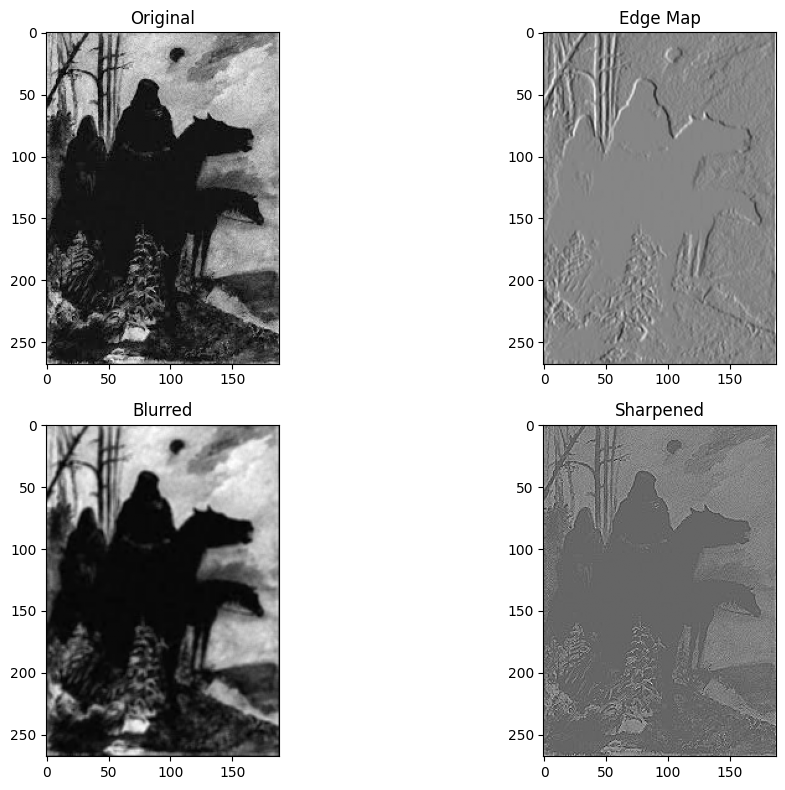

In [2]:
import cv2
import matplotlib.pyplot as plt

# image_path = "luffy-bw.jpg"
# image_path = "luffy-orignal.jpg"
image_path = "knight.jpg"
image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

# kernels
edge_kernel = np.array([[-1,  0,  1],
                        [-2,  0,  2],
                        [-1,  0,  1]], dtype=np.float32)

blur_kernel = np.ones((3, 3), dtype=np.float32) / 9.0

sharpen_kernel = np.array([[ 0, -1,  0],
                           [-1,  5, -1],
                           [ 0, -1,  0]], dtype=np.float32)

# Convolve with each kernel
edge_map   = imageProcessor(image_gray, edge_kernel, stride=1, padding='same', mode='convolution')
blurred    = imageProcessor(image_gray, blur_kernel, stride=1, padding='same', mode='convolution')
sharpened  = imageProcessor(image_gray, sharpen_kernel, stride=1, padding='same', mode='convolution')

# Display results
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1); plt.imshow(image_gray, cmap='gray'); plt.title("Original")
plt.subplot(2,2,2); plt.imshow(edge_map, cmap='gray');  plt.title("Edge Map")
plt.subplot(2,2,3); plt.imshow(blurred, cmap='gray');   plt.title("Blurred")
plt.subplot(2,2,4); plt.imshow(sharpened, cmap='gray'); plt.title("Sharpened")
plt.tight_layout()
plt.show()


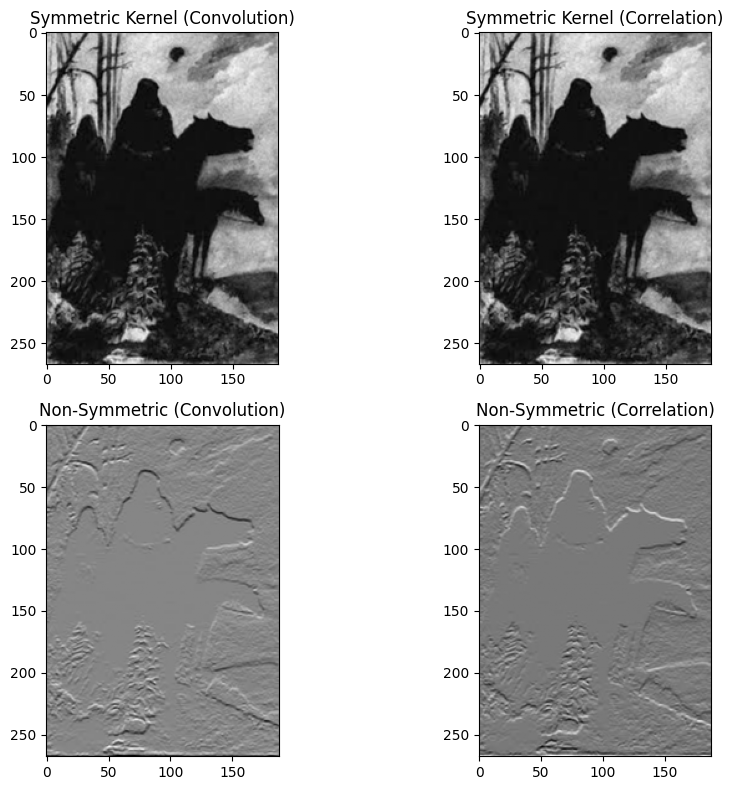

In [3]:
symmetric_kernel = np.array([[0.25, 0.25],
                             [0.25, 0.25]], dtype=np.float32)

nonsymmetric_kernel = np.array([[ 1,  2,  1],
                                [ 0,  0,  0],
                                [-1, -2, -1]], dtype=np.float32)

# Convolution vs Correlation for the symmetric kernel
sym_conv = imageProcessor(image_gray, symmetric_kernel, padding='same', mode='convolution')
sym_corr = imageProcessor(image_gray, symmetric_kernel, padding='same', mode='correlation')

# Convolution vs Correlation for the non-symmetric kernel
nonsym_conv = imageProcessor(image_gray, nonsymmetric_kernel, padding='same', mode='convolution')
nonsym_corr = imageProcessor(image_gray, nonsymmetric_kernel, padding='same', mode='correlation')

# Show them
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1); plt.imshow(sym_conv, cmap='gray'); plt.title("Symmetric Kernel (Convolution)")
plt.subplot(2,2,2); plt.imshow(sym_corr, cmap='gray'); plt.title("Symmetric Kernel (Correlation)")
plt.subplot(2,2,3); plt.imshow(nonsym_conv, cmap='gray'); plt.title("Non-Symmetric (Convolution)")
plt.subplot(2,2,4); plt.imshow(nonsym_corr, cmap='gray'); plt.title("Non-Symmetric (Correlation)")
plt.tight_layout()
plt.show()
